# Training UNet for drop segmentation

In [1]:
import torch

In [2]:
config = {
    "lr": 0.01,
    "batch_size": 8,
    "epochs": 10,
    "image_dir": '../../data/stereo/train/image',
    "mask_dir": '../../data/stereo/train/mask',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint": "checkpoint.pt"
}
print(f"Training using {config['device']}")

Training using cpu


In [3]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
import dataset
importlib.reload(dataset)
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    crop_shape=(256, 256)
)

train_dataset, val_dataset = dataset.random_split(0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val: {len(val_dataset)} images, {len(val_loader)} batches')

Loaded 678 images

Train: 611 images, 77 batches
Val: 67 images, 9 batches


In [5]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet
from unet import init_all
model = UNet(3).to(config['device'])
init_all(model, torch.nn.init.normal_, mean=0., std=1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

model.train()

C:\Users\KIR\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


UNet(
  (ups): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReL

In [10]:
def check_accuracy_and_save(model, optimizer, epoch, train_loss):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
    }, config["checkpoint"])

    dice_score = 0
    model.eval()
    with torch.no_grad():
        for x, y in val_dataset:
            x = x.to(config['device'])
            y = y.to(config['device'])

            preds = torch.sigmoid(model(x))
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
    print(f"Dice Score = {dice_score/len(val_dataset)}")
    model.train()

In [11]:
from tqdm import tqdm
def train():
    for epoch in range(config['epochs']):
        loader = tqdm(train_loader)
        losses = []
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            print(image.shape)
            with torch.cuda.amp.autocast():
                pred = model(image)
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss = loss.item()
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)
        mean_loss = sum(losses) / len(losses)
        check_accuracy_and_save(model, optimizer, epoch, mean_loss)

In [12]:
# Train the model
if __name__ == "__main__":
    train()

  0%|          | 0/77 [00:00<?, ?it/s]C:\Users\KIR\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


torch.Size([8, 3, 256, 256])


  1%|▏         | 1/77 [00:12<15:57, 12.59s/it, loss=2.87]

torch.Size([8, 3, 256, 256])


  3%|▎         | 2/77 [00:23<14:46, 11.82s/it, loss=2]   

torch.Size([8, 3, 256, 256])


  4%|▍         | 3/77 [00:35<14:15, 11.56s/it, loss=1.3]

torch.Size([8, 3, 256, 256])


  5%|▌         | 4/77 [00:46<13:50, 11.38s/it, loss=0.816]

torch.Size([8, 3, 256, 256])


  6%|▋         | 5/77 [00:57<13:34, 11.31s/it, loss=0.615]

torch.Size([8, 3, 256, 256])


  8%|▊         | 6/77 [01:08<13:16, 11.22s/it, loss=0.612]

torch.Size([8, 3, 256, 256])


  9%|▉         | 7/77 [01:19<12:58, 11.12s/it, loss=0.907]

torch.Size([8, 3, 256, 256])


 10%|█         | 8/77 [01:30<12:52, 11.19s/it, loss=0.765]

torch.Size([8, 3, 256, 256])


 12%|█▏        | 9/77 [01:41<12:35, 11.11s/it, loss=1.08] 

torch.Size([8, 3, 256, 256])


 13%|█▎        | 10/77 [01:52<12:25, 11.12s/it, loss=0.517]

torch.Size([8, 3, 256, 256])


 14%|█▍        | 11/77 [02:03<12:10, 11.07s/it, loss=0.586]

torch.Size([8, 3, 256, 256])


 16%|█▌        | 12/77 [02:14<12:01, 11.11s/it, loss=0.908]

torch.Size([8, 3, 256, 256])


 17%|█▋        | 13/77 [02:25<11:46, 11.04s/it, loss=0.684]

torch.Size([8, 3, 256, 256])


 17%|█▋        | 13/77 [02:37<12:55, 12.12s/it, loss=0.684]


KeyboardInterrupt: 

# Estimation

In [13]:
def get_full_prediction(model, x, y):
    image_np = x.detach().numpy()[0][0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    return image_np, gt_np, pred_np

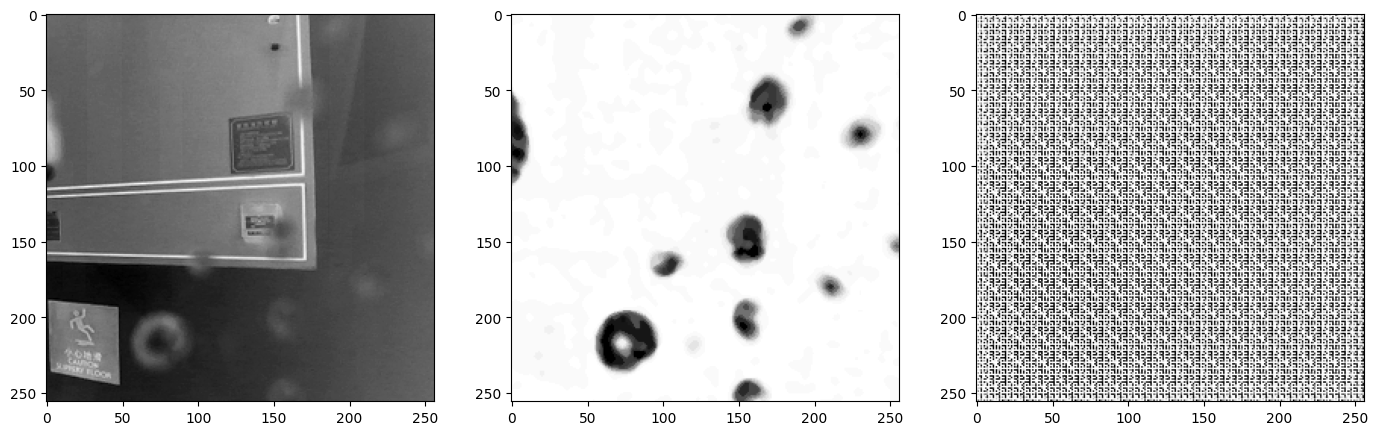

In [14]:
idx = 1
x, y = val_dataset.dataset[idx]
x = torch.stack([x])
y = torch.stack([y])
x, y, pred = get_full_prediction(model, x, y)
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(17, 10))
axs[0].imshow(x, cmap='gray_r')
axs[1].imshow(y, cmap='gray_r')
axs[2].imshow(pred, cmap='gray_r')